# Импорты

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Настройка отображения

In [26]:
sns.set(style="whitegrid")

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

plt.rcParams['figure.figsize'] = (12, 6)
plt.style.use('seaborn-v0_8-darkgrid')

# Загружаем данные

In [27]:
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')
sample_submission_df = pd.read_csv('data/sampleSubmission.csv')

# EDA

# Общая информация о данных

In [28]:
print("=== TRAIN ===")
print(train_df.info())
print("\n=== TEST ===")
print(test_df.info())
print("\n=== SAMPLE SUBMISSION ===")
print(sample_submission_df.info())

=== TRAIN ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB
None

=== TEST ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    6493 non-null 

# Преобразование datetime и создание признаков времени

In [29]:
# Конвертация datetime
train_df['datetime'] = pd.to_datetime(train_df['datetime'])
test_df['datetime'] = pd.to_datetime(test_df['datetime'])

# Добавим признаки времени
for df in [train_df, test_df]:
    df['year'] = df['datetime'].dt.year
    df['month'] = df['datetime'].dt.month
    df['day'] = df['datetime'].dt.day
    df['hour'] = df['datetime'].dt.hour
    df['weekday'] = df['datetime'].dt.weekday  # 0=Mon, 6=Sun
    df['is_weekend'] = (df['weekday'] >= 5).astype(int)

# Основные статистики

In [30]:
train_df.describe()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,weekday,is_weekend
count,10886,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2011-12-27 05:56:22.399411968,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132,2011.501929,6.521495,9.992559,11.541613,3.013963,0.290557
min,2011-01-01 00:00:00,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000,2011.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,2011-07-02 07:15:00,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000,2011.000000,4.000000,5.000000,6.000000,1.000000,0.000000
50%,2012-01-01 20:30:00,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000,2012.000000,7.000000,10.000000,12.000000,3.000000,0.000000
75%,2012-07-01 12:45:00,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000,2012.000000,10.000000,15.000000,18.000000,5.000000,1.000000
max,2012-12-19 23:00:00,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000,2012.000000,12.000000,19.000000,23.000000,6.000000,1.000000
std,NaN,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454,0.500019,3.444373,5.476608,6.915838,2.004585,0.454040


# Анализ временных паттернов

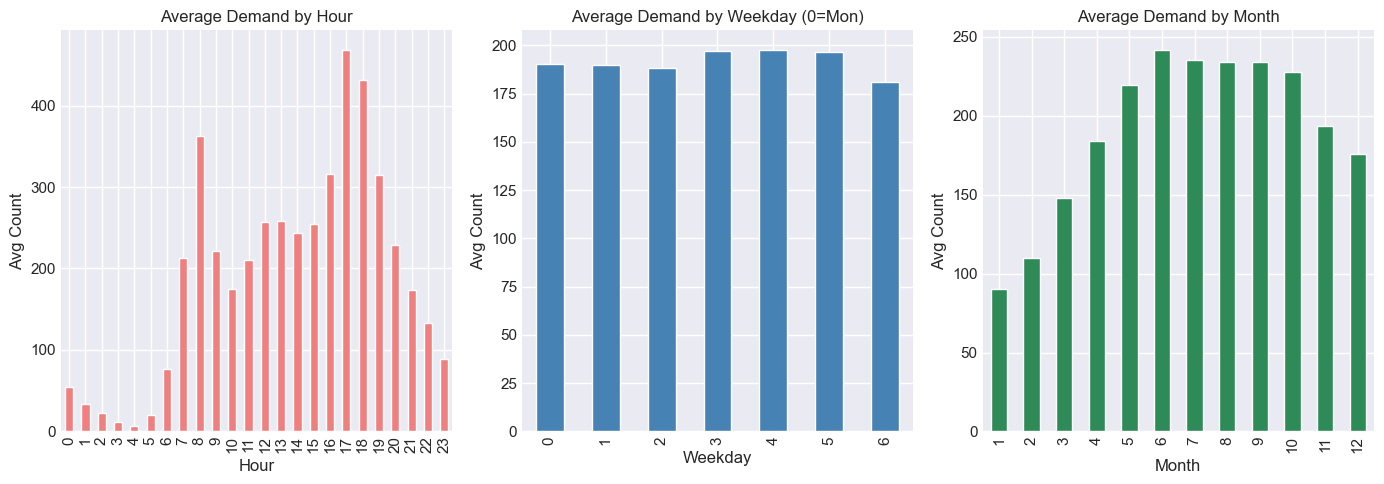

In [31]:
plt.figure(figsize=(14, 5))

# По часам
hourly = train_df.groupby('hour')['count'].mean()
plt.subplot(1, 3, 1)
hourly.plot(kind='bar', color='lightcoral')
plt.title('Average Demand by Hour')
plt.xlabel('Hour'); plt.ylabel('Avg Count')

# По дням недели
weekday = train_df.groupby('weekday')['count'].mean()
plt.subplot(1, 3, 2)
weekday.plot(kind='bar', color='steelblue')
plt.title('Average Demand by Weekday (0=Mon)')
plt.xlabel('Weekday'); plt.ylabel('Avg Count')

# По месяцам
monthly = train_df.groupby('month')['count'].mean()
plt.subplot(1, 3, 3)
monthly.plot(kind='bar', color='seagreen')
plt.title('Average Demand by Month')
plt.xlabel('Month'); plt.ylabel('Avg Count')

plt.tight_layout()
plt.show()